## Imports 

In [16]:
import pytensor
import pytensor.tensor as pt
import arviz as az
import jax
import numpy as np
import numpyro
import pymc as pm
from pymc import sampling_jax

# WFPT and LAN are two factory classes
from hssm import wfpt
from hssm.wfpt import lan
import ssms.basic_simulators

numpyro.set_host_device_count(jax.local_device_count())

## Load Data 
Simulated dataset should include the following columns: 

1. response: the subject's choice on a particular trial (0=lower boundary, 1=upper boundary)
2. rt: the reaction time associated with the subject's choice

In [17]:
# Simulate some data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.3]
obs_angle = ssms.basic_simulators.simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)
obs = np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]])
obs

array([[0.98399734, 1.        ],
       [1.29999328, 1.        ],
       [2.1740222 , 1.        ],
       ...,
       [1.47399104, 1.        ],
       [1.16699505, 1.        ],
       [1.59099495, 1.        ]])

## Choose a log-likehood
Created a basic Wiener First Passage Time Distribution log-likehood .

In [11]:
WFPT_base = wfpt.make_ssm_distribution(
    model="base",
    list_params=["v", "a", "z", "t", "sv"],
)

## Fitting log-likelihood model into pymc model 
PyMC allows us to build WFPT mode and fit them using Markov chain Monte Carlo (MCMC) methods.

In [13]:
pytensor.config.floatX = "float32"

with pm.Model() as m_angle:
    v = pm.Uniform("v", -3.0, 3.0)
    sv = pm.Uniform("sv", 0.0, 1.2)
    a = pm.Uniform("a", 2.0, 3.5)
    z = pm.Uniform("z", 0.1, 0.9)
    t = pm.Uniform("t", 0.0, 2.0)

    rt = WFPT_base(
        name="rt",
        v=v,
        sv=sv,
        a=a,
        z=z,
        t=t,
        observed=obs,
    )

    # setting mp_ctx to "forkserver" fixes parallel sampling on M1 Macs
    trace_angle_ddm_base = pm.sample(cores=2, draws=500, tune=500, mp_ctx="forkserver")

/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/aomar7/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Model Evaluation 

### We now want to analyze our estimated model, summary() from arviz package will print a table of summary statistics for each parameters' posterior.

In [14]:
az.summary(trace_angle_nuts)

arviz - WARNING - Shape validation failed: input_shape: (1, 155), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
v   0.232  0.043   0.162    0.306      0.004    0.003     136.0      90.0   
a   0.308  0.007   0.300    0.323      0.001    0.001      54.0      51.0   
z   0.900  0.000   0.900    0.900      0.000    0.000     100.0     109.0   
t   0.496  0.014   0.473    0.523      0.001    0.001     191.0     172.0   
sv  0.657  0.001   0.655    0.659      0.000    0.000      43.0     109.0   

    r_hat  
v     NaN  
a     NaN  
z     NaN  
t     NaN  
sv    NaN

### The inference algorithm, MCMC, requires the chains of the model to have properly converged. While there is no way to guarantee convergence for a finite set of samples in MCMC, there are many heuristics that allow you identify problems of convergence. One main analysis to look at is the trace, the autocorrelation, and the marginal posterior. You can plot these using the plot_posteriors() function. For the sake of brevity we only plot three here. In practice, however, you will always want to examine all of them.

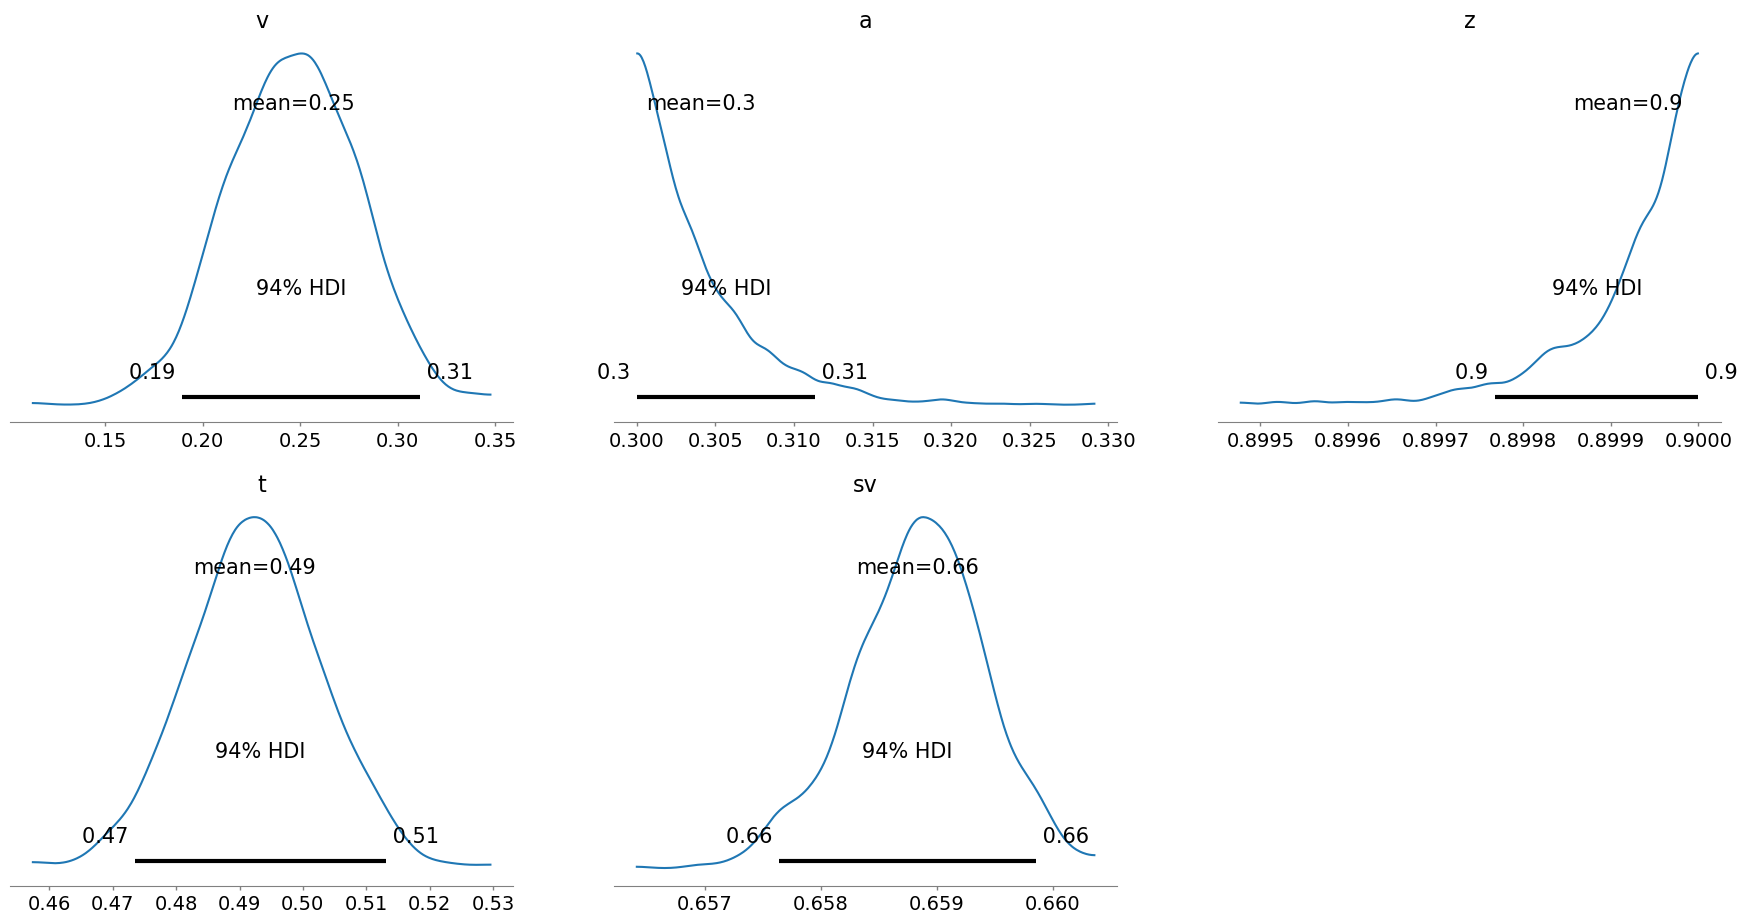

In [14]:
az.plot_posterior(trace_angle_nuts);

## Convergence Status.

### Trace plots help us verify the convergence of model. In general, a largely overlapped distribution across samples from different chains indicates the convergence.



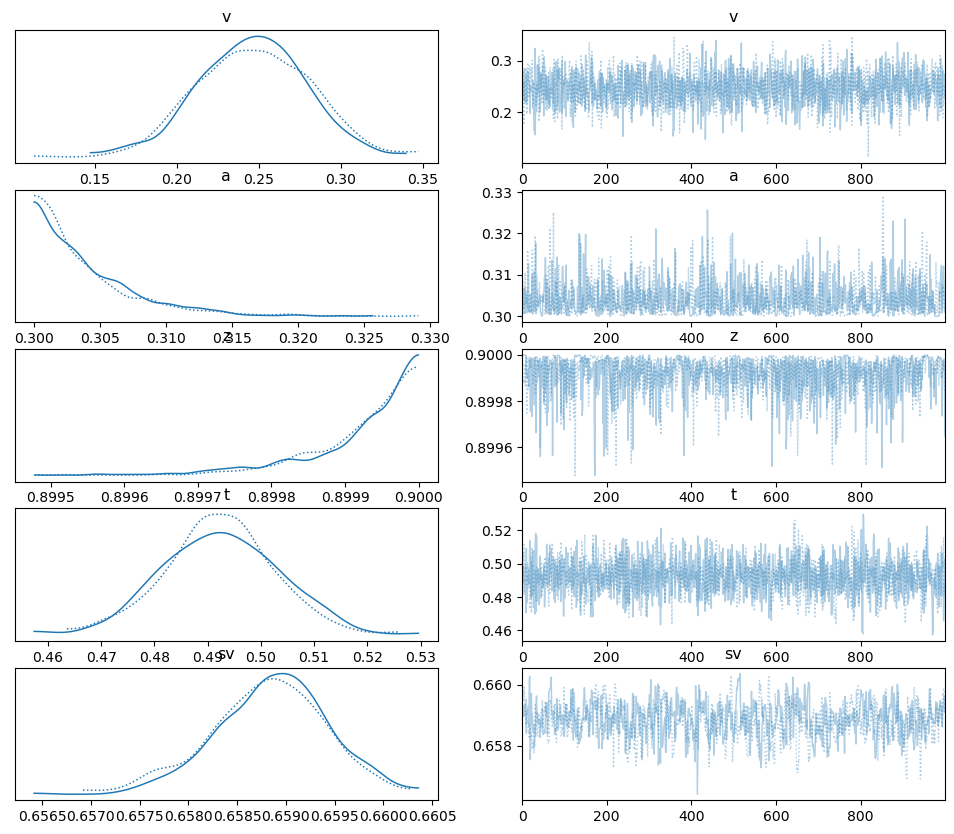

In [15]:
az.plot_trace(trace_angle_nuts);

### You want the autocorrection to be as flat and close to 0 as possible. 

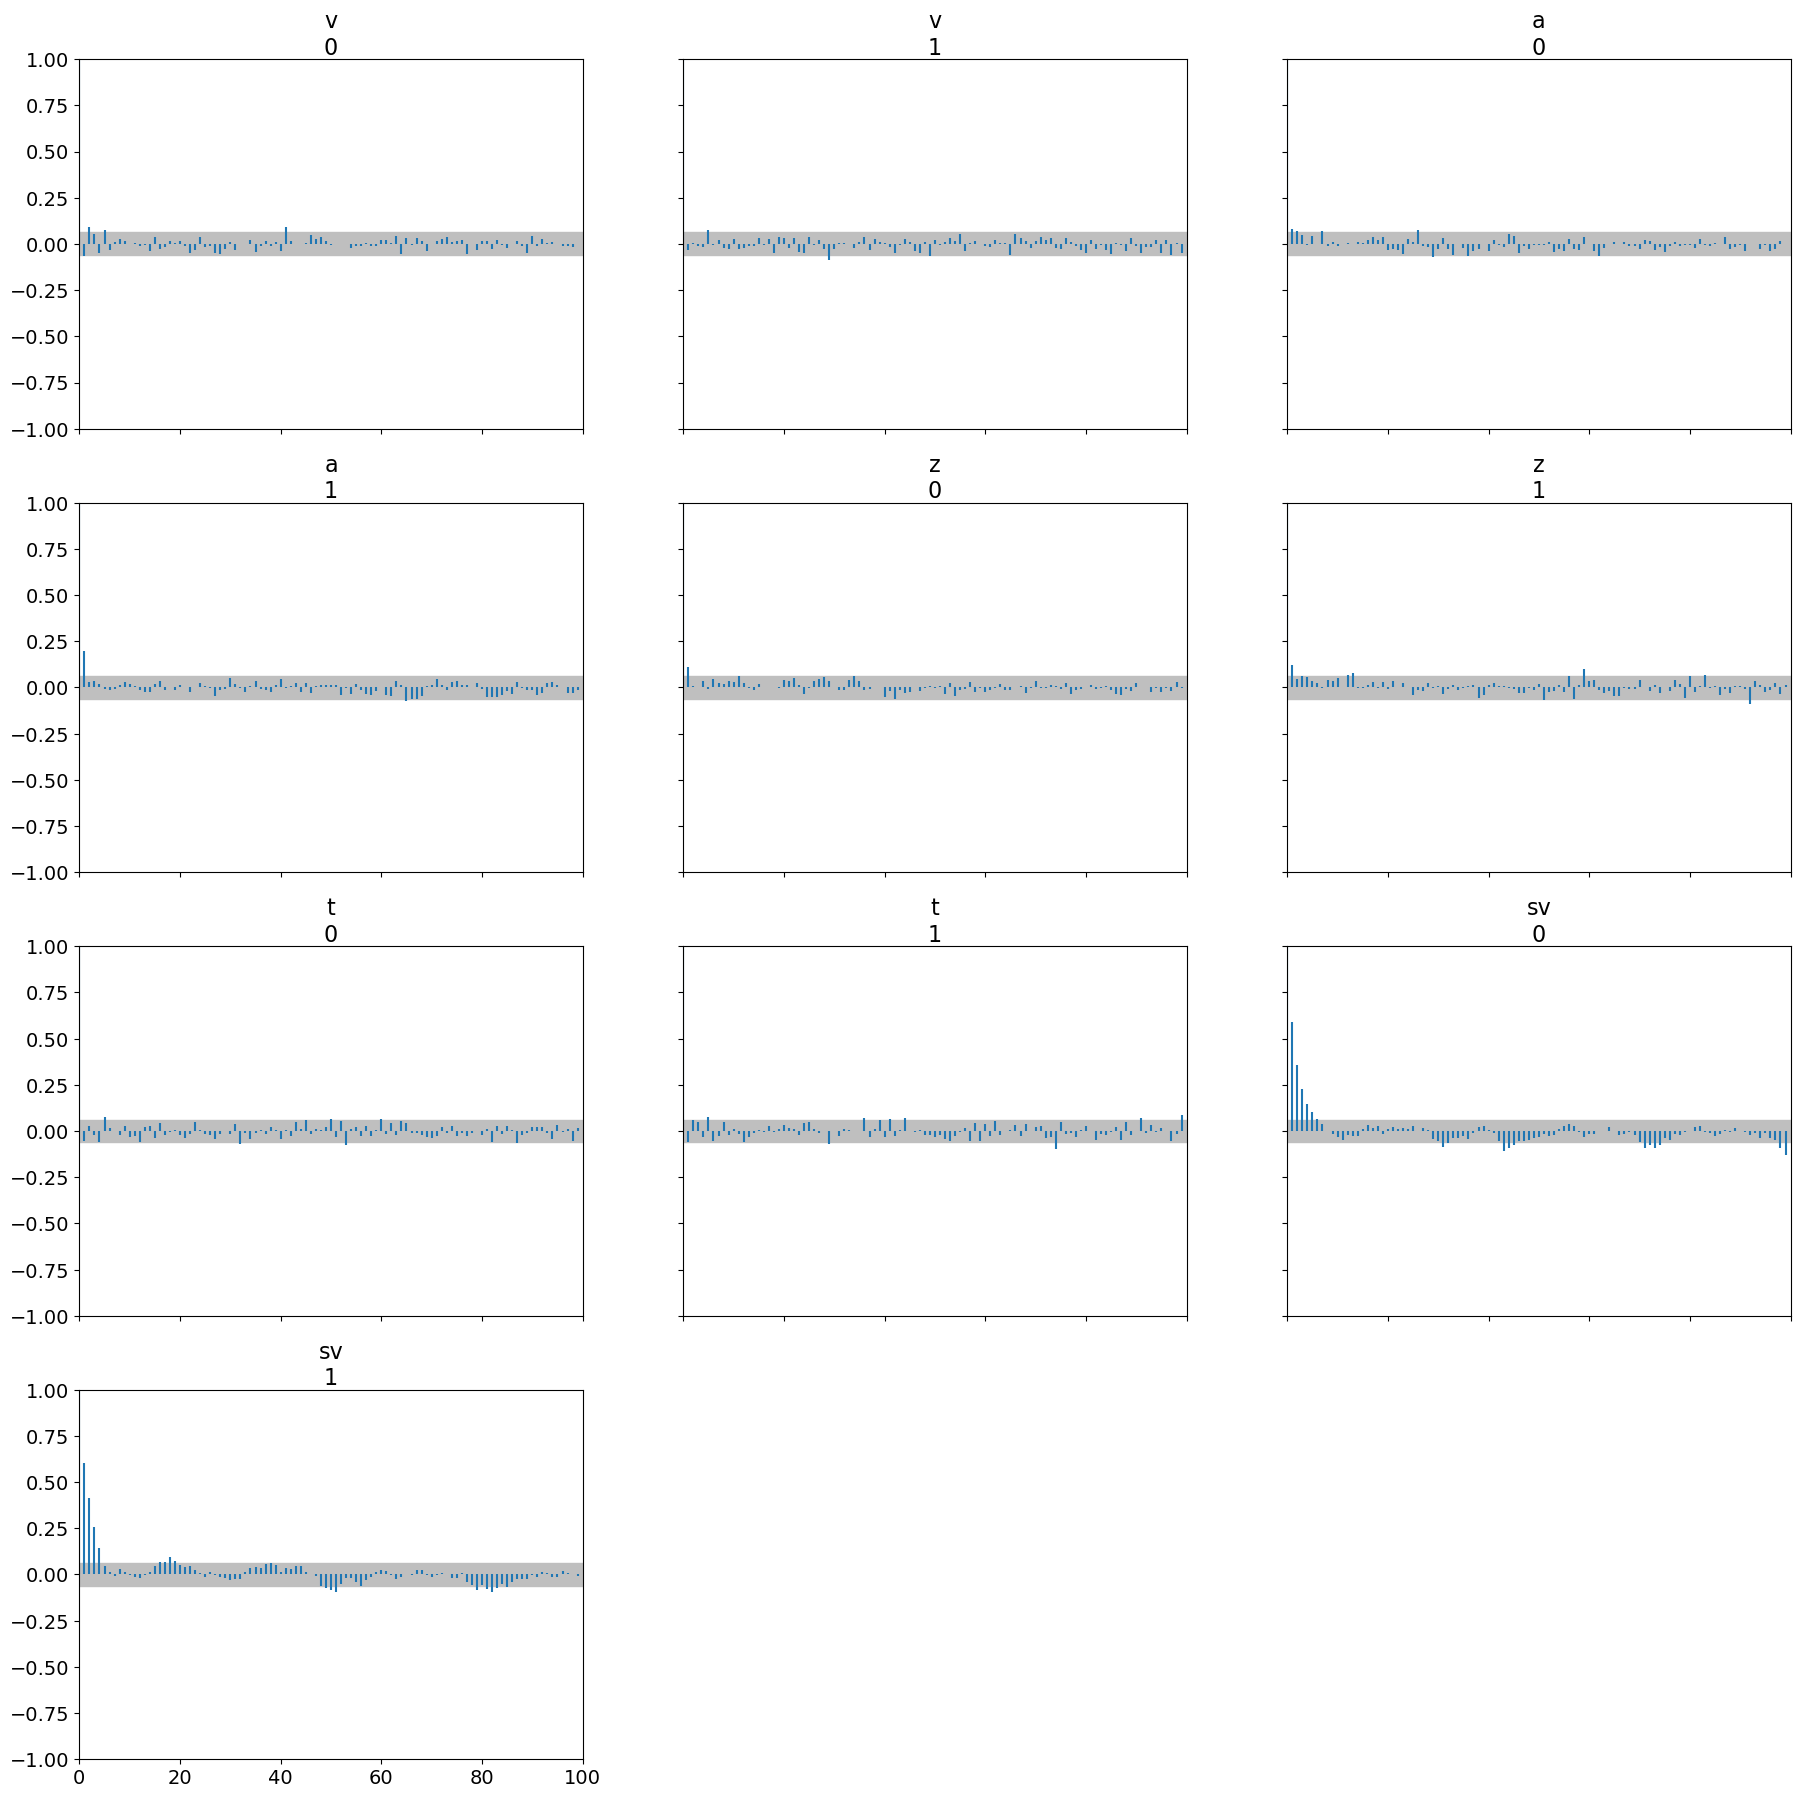

In [16]:
az.plot_autocorr(trace_angle_nuts);

### The Gelman-Rubin statistic provides a more formal test for convergence that compares the intra-chain variance to the intra-chain variance of different runs of the same model.

In [14]:
az.rhat(trace_angle_nuts)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    v        float64 1.002
    a        float64 1.0
    z        float64 1.0
    t        float64 1.002
    sv       float64 1.001

### Main check in The Gelman-Rubin statistic - all data variables should be close to 1. 

## Other Plots

array([<AxesSubplot: title={'center': '94.0% HDI'}>,
       <AxesSubplot: title={'center': 'ess'}>,
       <AxesSubplot: title={'center': 'r_hat'}>], dtype=object)

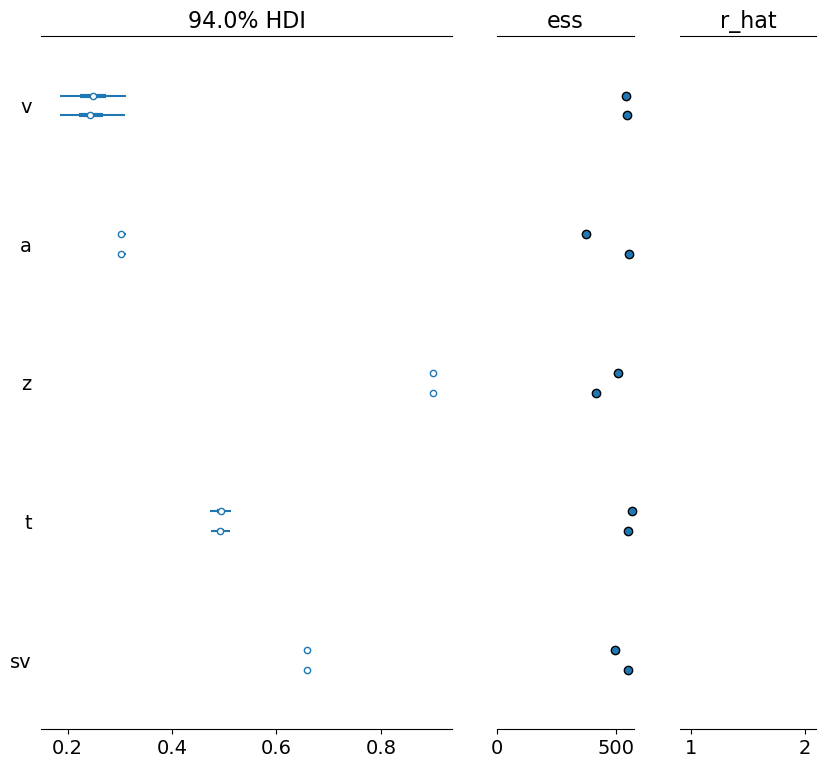

In [21]:
az.plot_forest(trace_angle_nuts, ess=True, r_hat=True)

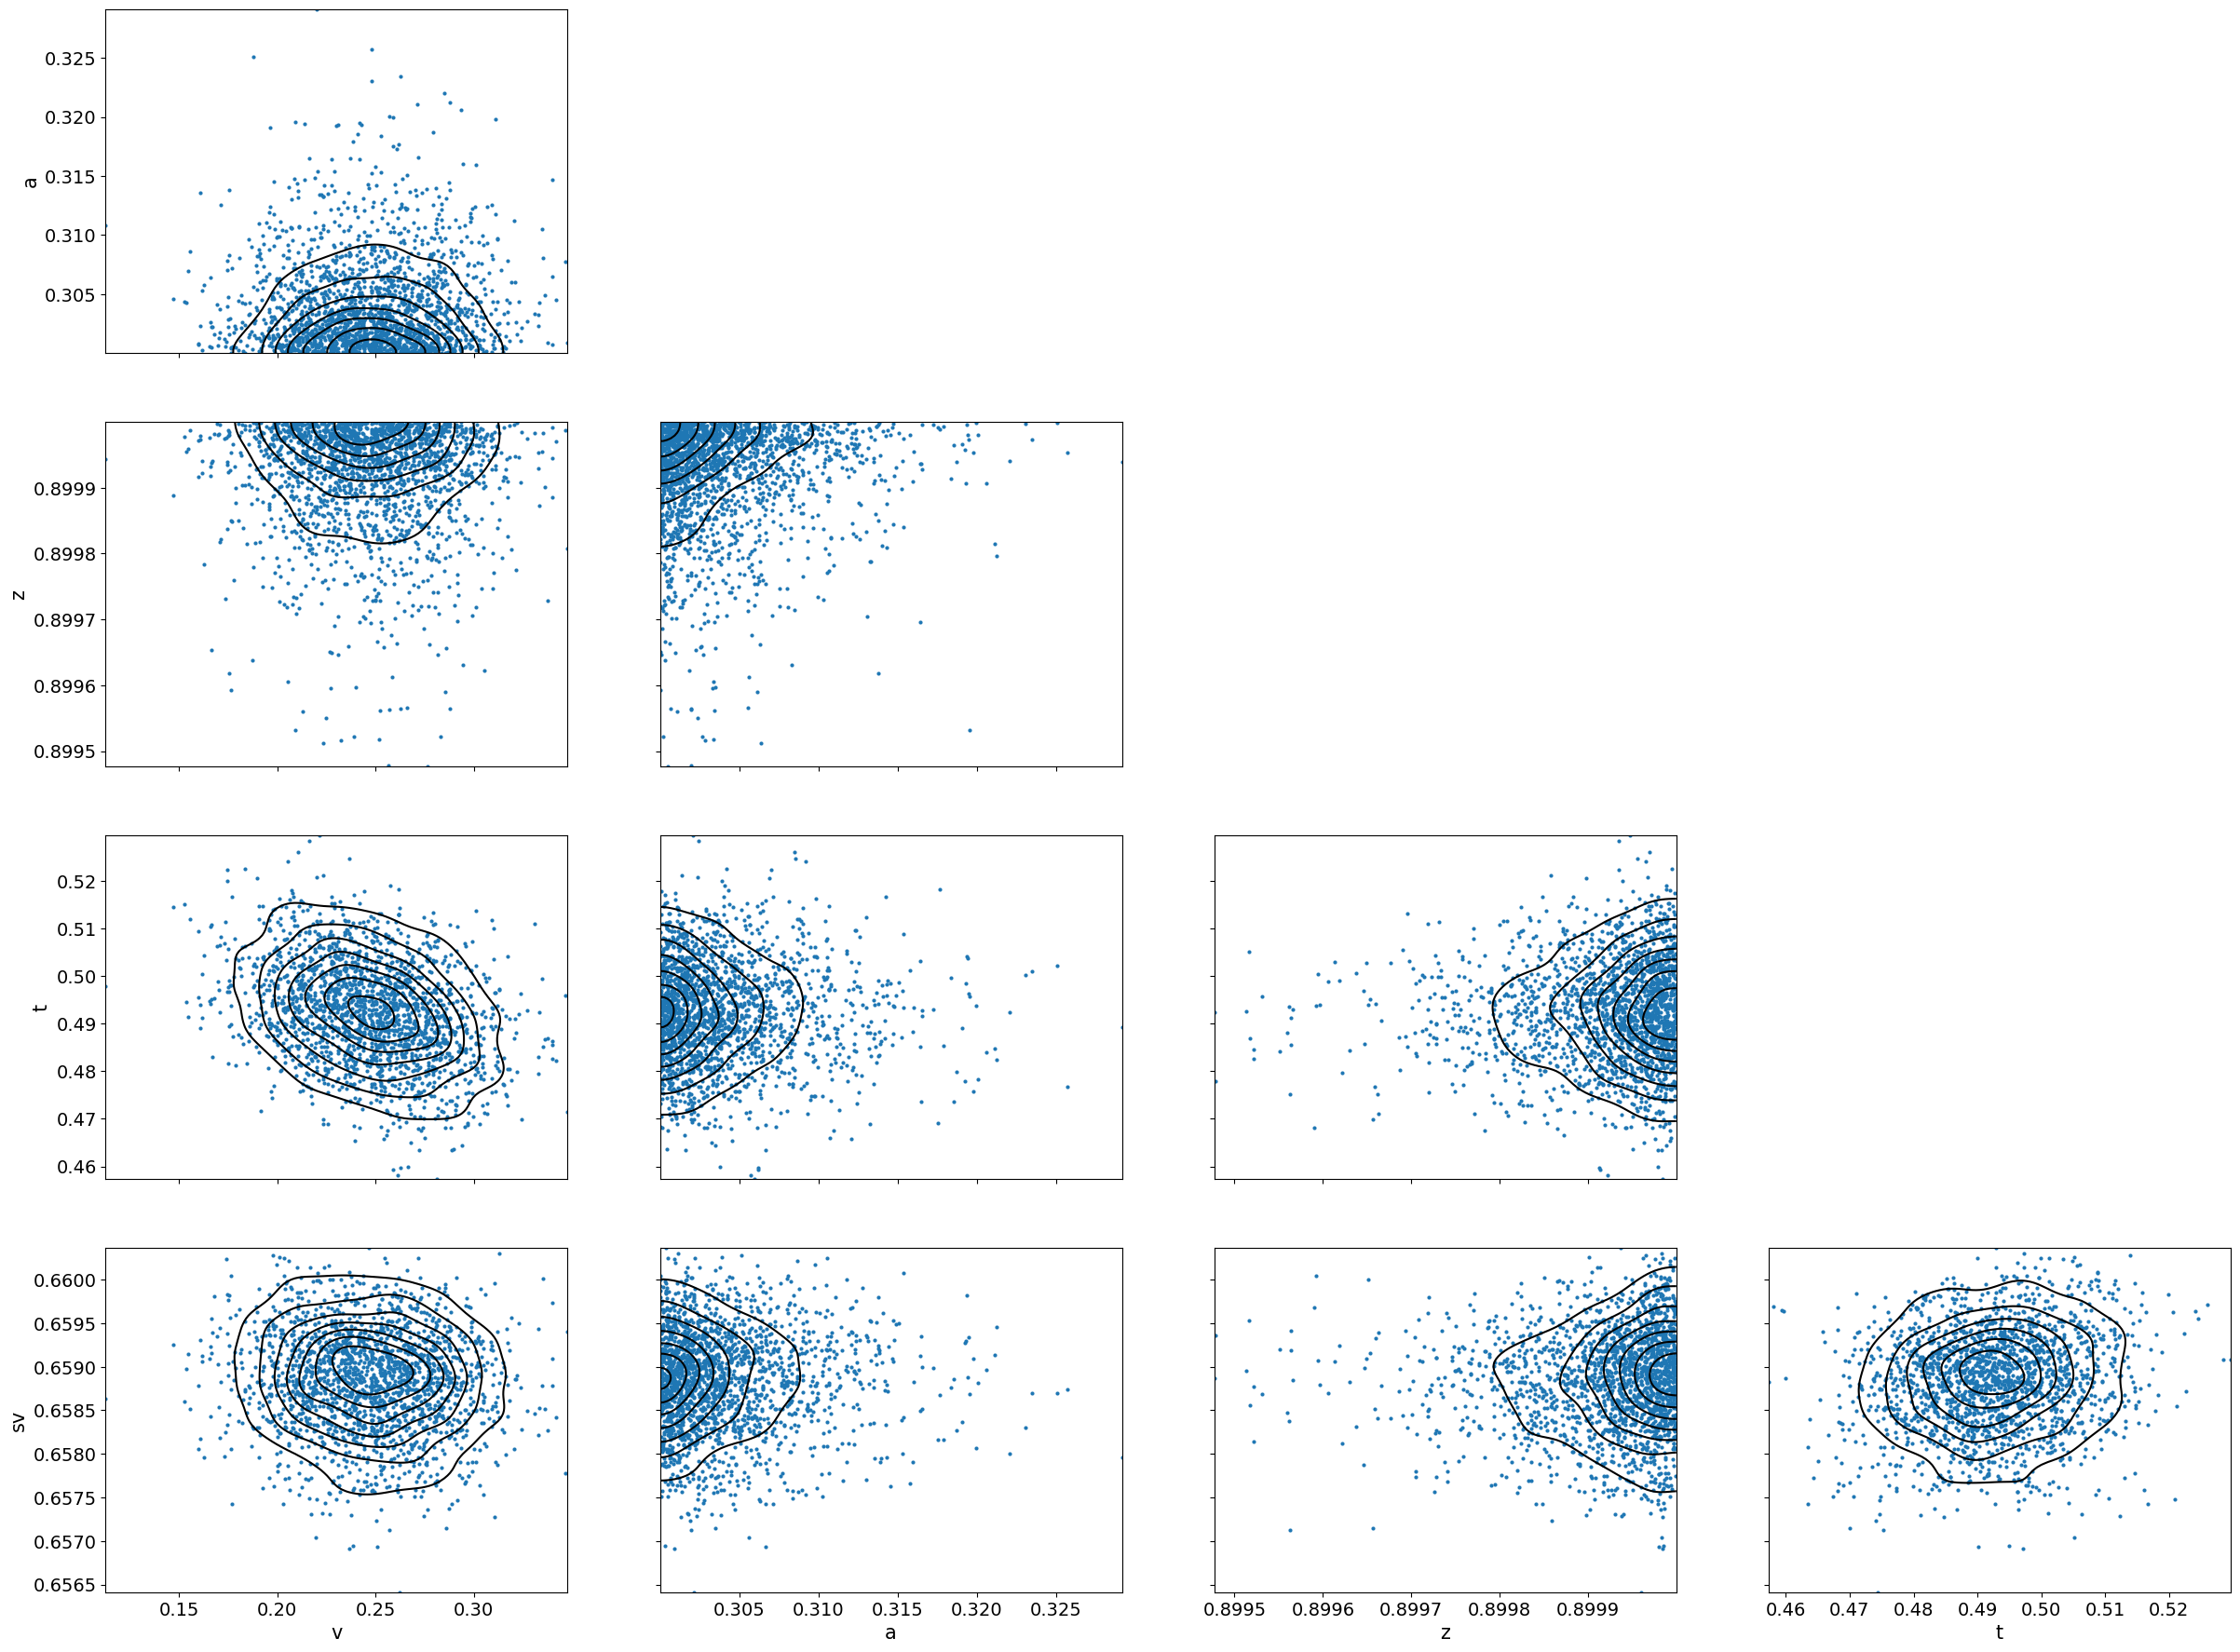

In [22]:
az.plot_pair(
    trace_angle_nuts,
    kind=["scatter", "kde"],
);